In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

df= pd.read_csv("Data/opsd_germany_daily.csv")
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [2]:
df['Date']= pd.to_datetime(df['Date'])

df= df.set_index('Date')

In [3]:
df= df.resample('M').mean()
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,1461.442065,NaN,NaN,NaN
2006-02-28,1467.106893,NaN,NaN,NaN
2006-03-31,1418.649161,NaN,NaN,NaN
2006-04-30,1275.058900,NaN,NaN,NaN
2006-05-31,1253.488484,NaN,NaN,NaN
...,...,...,...,...
2017-08-31,1291.283022,177.412839,148.477677,325.890516
2017-09-30,1335.952031,209.591000,102.643033,312.234033
2017-10-31,1366.297385,402.583774,68.727645,471.311419


In [4]:
df= df.drop(['Wind', 'Solar','Wind+Solar'], axis= 1)
df

,Consumption
Date,
2006-01-31,1461.442065
2006-02-28,1467.106893
2006-03-31,1418.649161
2006-04-30,1275.058900
2006-05-31,1253.488484
...,...
2017-08-31,1291.283022
2017-09-30,1335.952031
2017-10-31,1366.297385


In [5]:
df.isna().sum()

Consumption    0
dtype: int64

In [6]:
df= df.dropna()

In [7]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [16]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [9]:
# ARIMA

# Check for seasonal differcing
nsdiffs(df, m = 12)

0

In [10]:
df_diff =df.diff().dropna()

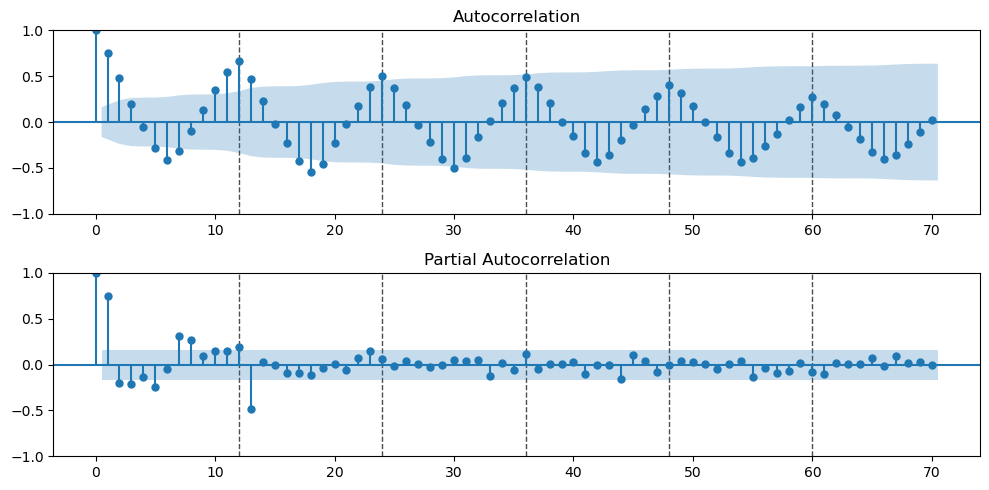

In [11]:
plot_acf_pacf(df, annotate_seas=True, m = 12, nlags = 70);

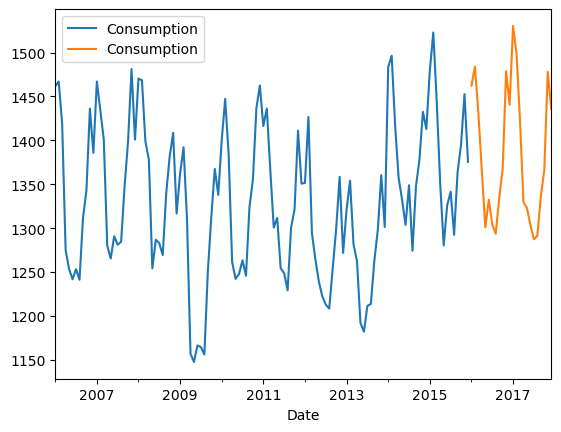

In [12]:
train, test = train_test_split(df, test_size=24)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [14]:
# Build the model 
p = 1  # AR component 

d = 0  # Number of differencing required to make stationary

q = 0 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  120
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -653.886
Date:                Wed, 07 Feb 2024   AIC                           1313.773
Time:                        01:55:07   BIC                           1322.135
Sample:                    01-31-2006   HQIC                          1317.169
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1334.9675     20.412     65.401      0.000    1294.961    1374.974
ar.L1          0.7558      0.074     10.171      0.000       0.610       0.901
sigma2      3143.5983    412.704      7.617      0.000    2334.713    3952.484
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.12   Prob(JB):                         0.99
Heteroskedasticity (H):               0.87   Skew:                             0.02
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 66.492
- MSE = 7,412.715
- RMSE = 86.097
- R^2 = -0.279
- MAPE = 4.63%


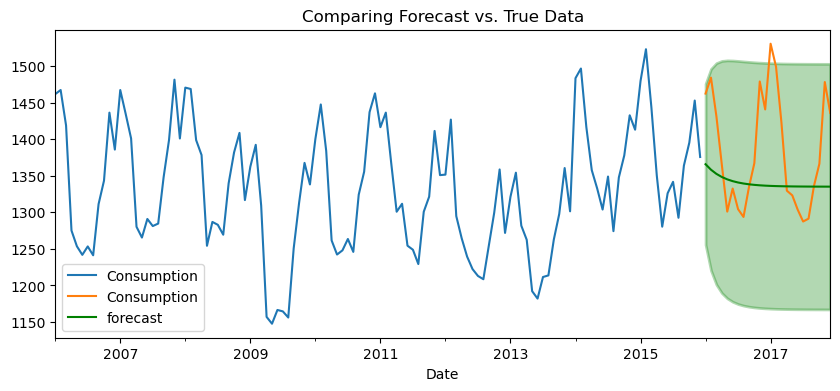

In [19]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [21]:
# SARIMA

D = nsdiffs(df, m =12)
print(f'D = {D}')

D = 0


In [22]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -602.870
Date:                            Wed, 07 Feb 2024   AIC                           1215.739
Time:                                    02:00:11   BIC                           1229.677
Sample:                                01-31-2006   HQIC                          1221.399
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.7435     57.823     23.014      0.000    1217.413    1444.074
ar.L1          0.7880      0.058     13.540      0.000       0.674       0.902
ar.S.L12       0.9953      0.011     91.722      0.000       0.974       1.017
ma.S.L12      -0.8616      0.157     -5.490      0.000      -1.169      -0.554
sigma2      1088.6898    201.404      5.406      0.000     693.945    1483.434
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                23.69
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.217
- MSE = 2,686.763
- RMSE = 51.834
- R^2 = 0.536
- MAPE = 3.30%


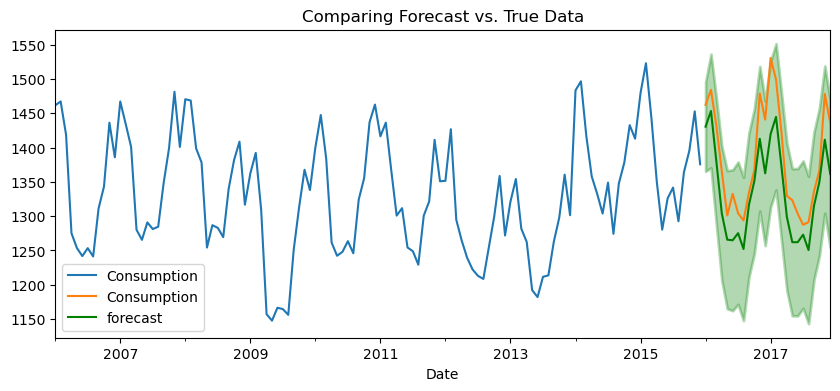

In [23]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

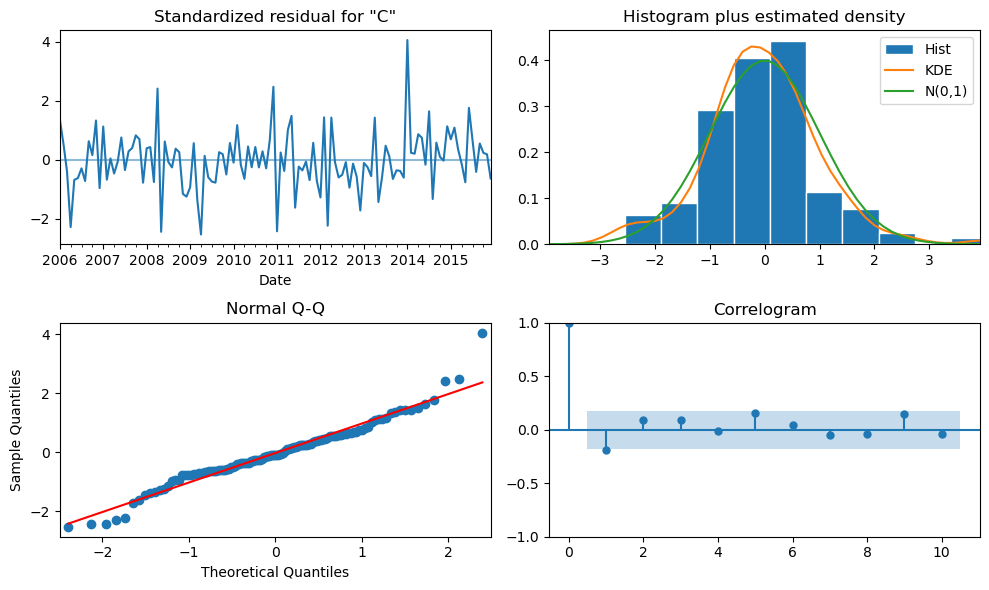

In [24]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()